# *DS261: AI for Medical Image Analysis*
## *Assignmnet-03*
### *Submitted By: Aman Pawar, MTech(1st Year), Department of Bioengineering SR NO:22761*

*Please ensure the following libraries are installed before you run the code below:*<br/>
```!pip intall medmnist scipy matplotlib seaborn tabulate```<br/>
```!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118```

### *Part-1*
### *Doing Necessaary Imports*


In [1]:
import numpy as np
from src import ans_01, ans_02, ans_03

### *Ans-1-a*

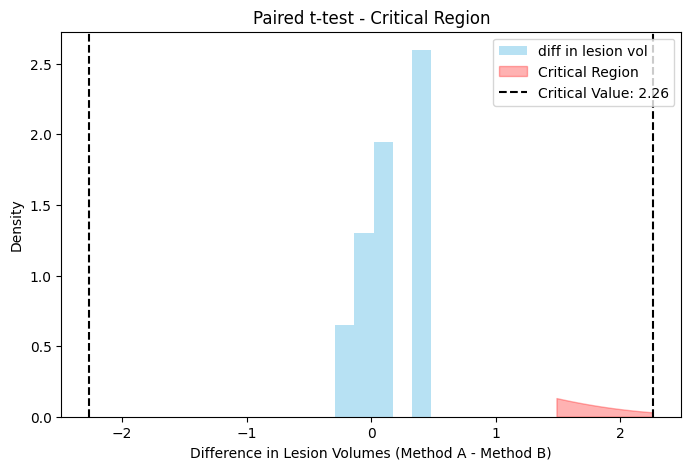

Test Statistic: 1.4770
Critical Value: ±2.2622
P-value: 0.0869


In [2]:
# Lesion volumes measured by methods A and B
lesion_volume_A = np.array([0.50, 0.58, 0.90, 1.17, 1.14, 1.25, 0.75, 1.22, 0.74, 0.80])
lesion_volume_B = np.array([0.79, 0.71, 0.82, 0.82, 0.73, 0.77, 0.72, 0.79, 0.72, 0.91])

ans_01.solve(lesion_volume_A, lesion_volume_B, alpha=0.05)

### *Ans-1-b*

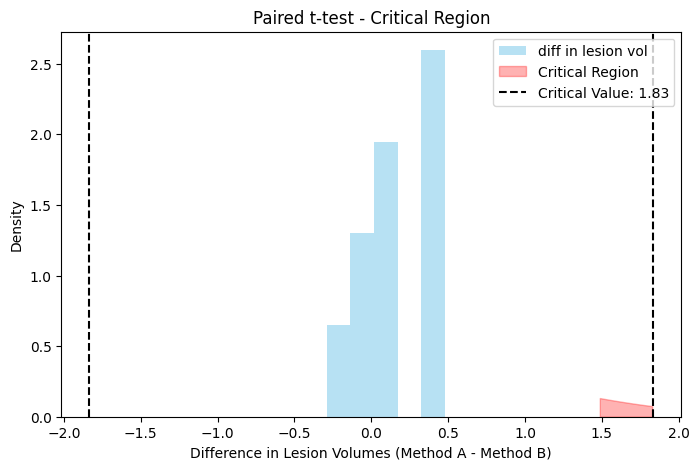

Test Statistic: 1.4770
Critical Value: ±1.8331
P-value: 0.0869


In [3]:
ans_01.solve2(lesion_volume_A, lesion_volume_B, alpha=0.05)

### *Ans-1-c*

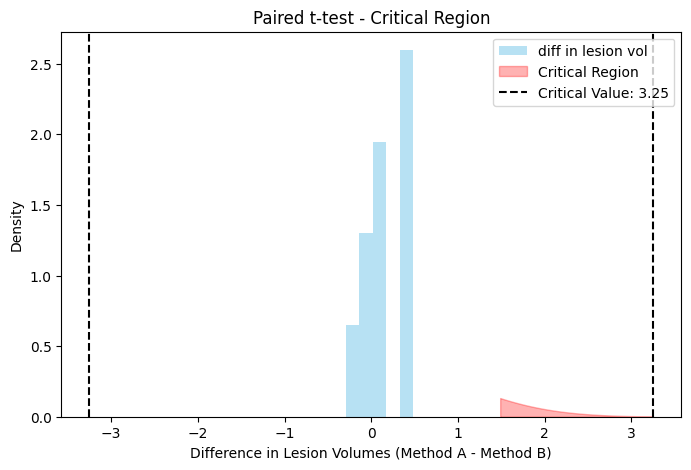

Test Statistic: 1.4770
Critical Value: ±3.2498
P-value: 0.0869


In [4]:
ans_01.solve(lesion_volume_A, lesion_volume_B, alpha=0.01)

### *Ans-2*

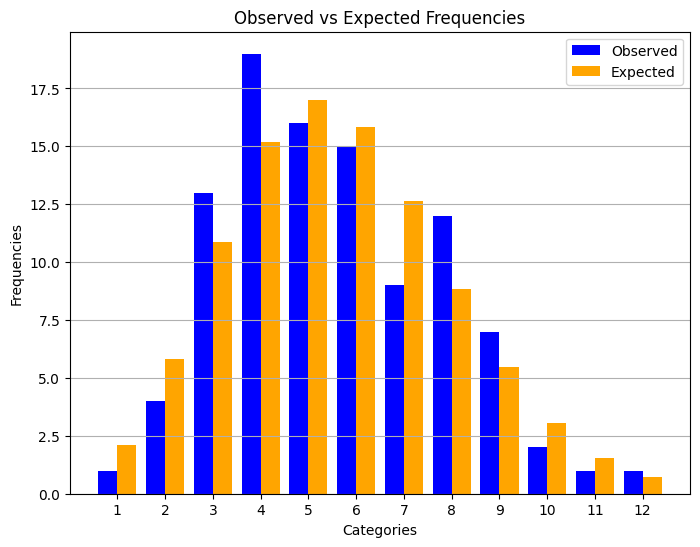

Chi-square statistic: 5.89004600683265
Critical value at alpha = 0.05 and df = 10: 18.307038053275146
The observed frequencies fit a Poisson distribution (fail to reject H0)


In [5]:
ans_02.solve()

### *Ans-3*

In [2]:
ans_03.solve()

                      df     sum_sq     mean_sq          F        PR(>F)
C(Nutrient)          1.0   29.27521   29.275210   5.532832  2.497936e-02
C(Age)               3.0  454.69923  151.566410  28.645106  3.439786e-09
C(Nutrient):C(Age)   3.0   27.34379    9.114597   1.722602  1.820629e-01
Residual            32.0  169.31776    5.291180        NaN           NaN

F-statistic for Nutrient: 5.532831995887513, p-value: 0.024979359808804828
F-statistic for Age: 28.64510562861211, p-value: 3.4397861200280045e-09
F-statistic for Interaction: 1.7226018896856075, p-value: 0.18206291537597424


### *Part-2*
### *Doing Necessary Imports*

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
from src import data, utils, architectures, trainer
import matplotlib.pyplot as plt
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda:1


### *Ans-2-a*
### *Preparing and Visualizing the dataset*

In [8]:
# Importing Data:
train_loader, val_loader, test_loader = data.get_data("bloodmnist", BATCH_SIZE =1024)

Using downloaded and verified file: /home/aman-aimi/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/aman-aimi/.medmnist/bloodmnist.npz
Train Ratio : 0.8, Val Ratio: 0.19999999999999996
Training Samples: 9567, Validation Samples: 2392, Test Samples: 3421


Visualtizing Data from the DataLoader...
The Shape of Image is : (3, 28, 28)


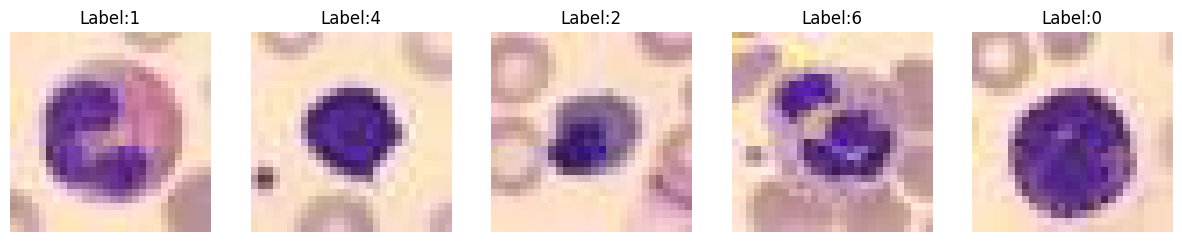

In [9]:
# Visulizing the Training Images
utils.make_images(train_loader)

### *Ans-2-b*
### *part i) VAE: Variational Autoencoder*
### *part ii) GAN: Generative Adverserial Network*

In [10]:
# Initialize the VAE model
latent_dim = 3*28*28  # Set the latent dimension
model = architectures.VAE(latent_dim)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the VAE model
trainer.train_vae(model, trainer.loss_function, optimizer, train_loader, val_loader, device, num_epochs=100)

Epoch 100/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  9.77it/s, Validation Loss=3.59e+5]


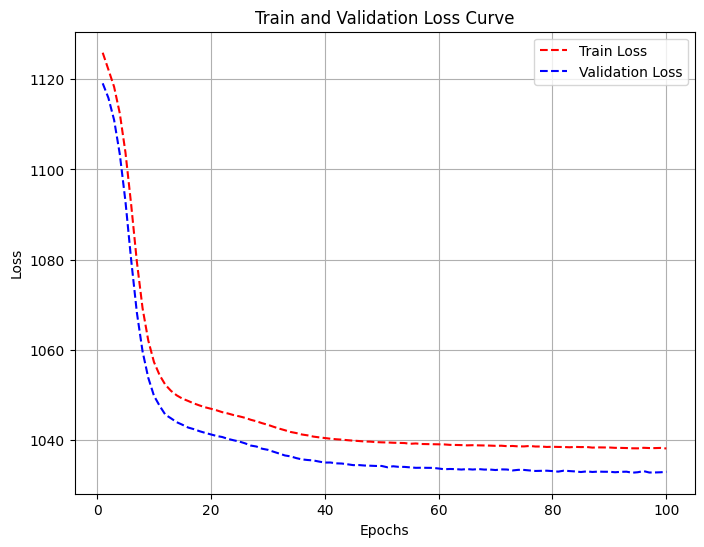

In [11]:
file_path = './Results/VAElosses.txt'
utils.plot_loss_curve(file_path)

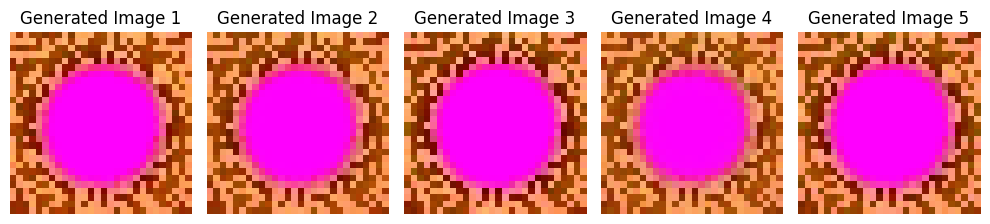

In [12]:

# Initialize the VAE model and load the trained weights
latent_dim = 28*28*3  # Set the latent dimension
model = architectures.VAE(latent_dim).to(device)
model.load_state_dict(torch.load('./ModelWeights/best_vae_model.pth', map_location=device))
model.eval()
# Function to generate an image from noise using the VAE decoder
def generate_image_from_noise(model, device, num_samples=5):
    with torch.no_grad():
        # Generate random noise
        random_noise = torch.randn(num_samples, latent_dim).to(device)
        # Decode the noise to generate an image
        generated_image = model.decode(random_noise).view(-1, 3, 28, 28)
        return generated_image.cpu().detach().numpy()

# Generate an image from noise using the trained VAE
generated_images = generate_image_from_noise(model, device)

# Display the generated image(s)
plt.figure(figsize=(10,5))
for i, img in enumerate(generated_images):
    plt.subplot(1, len(generated_images), i + 1)
    plt.imshow(img.transpose(1, 2, 0))  # Transpose to (H, W, C) for visualization
    plt.axis('off')
    plt.title(f'Generated Image {i+1}')

plt.tight_layout()
plt.show()

### *Ans-2-b-loss-on-test-data*

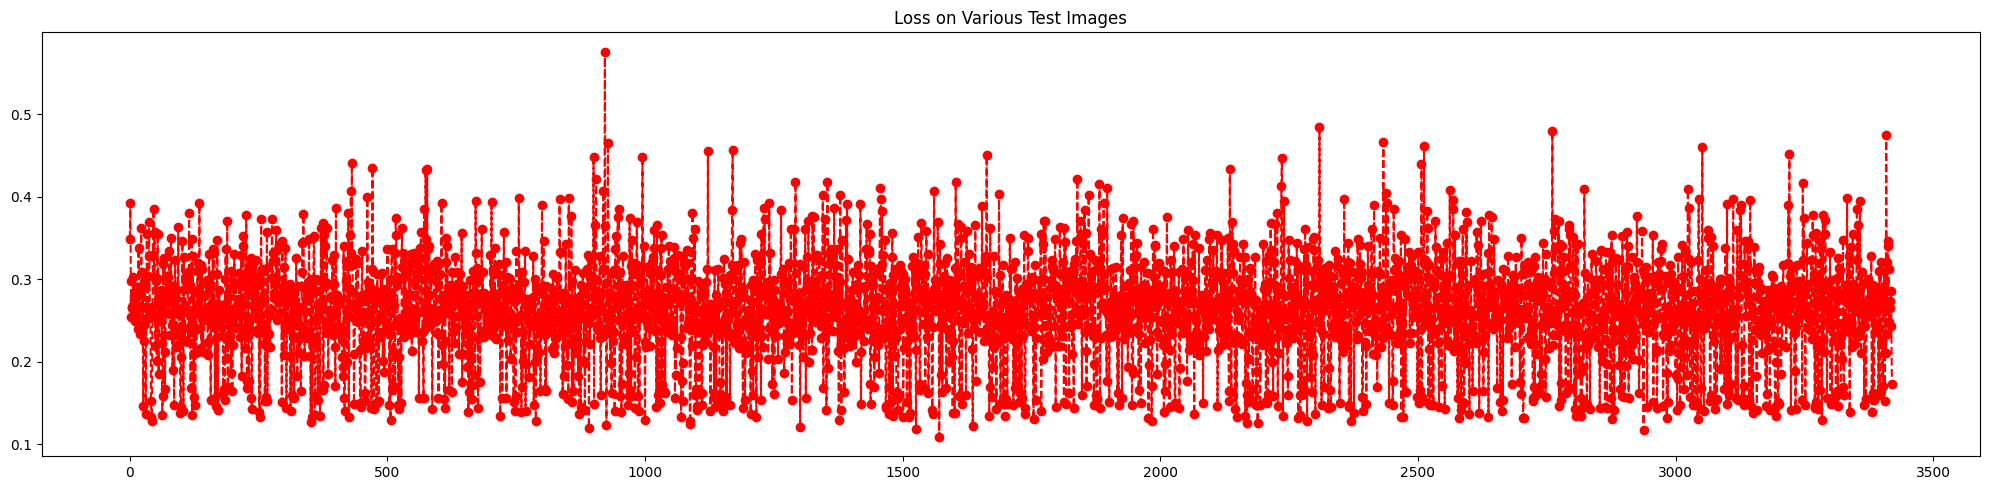

In [13]:
loss = MSELoss()
model.eval()
l_vae= []
for batch, label in test_loader:
    with torch.no_grad():
        for image in batch:
            generated_image = model.decode(image.reshape(-1,28*28*3).to(device)).view(-1, 3, 28, 28).to(device)
            l = loss(image.unsqueeze(dim=0).to(device), generated_image)
            l_vae.append(l.cpu().numpy())

plt.figure(figsize=(20,5))
plt.plot(l_vae, '--or')
plt.title("Loss on Various Test Images")
plt.tight_layout()
plt.show()

### *GAN: Vanilla Generative Adverserial Network*

In [14]:
# Initialize Generator, Discriminator, optimizers, loss function
num_epochs = 100
latent_size = 28*28*3
generator = architectures.Generator(latent_size).to(device)
discriminator = architectures.Discriminator().to(device)
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [15]:
trainer.run(generator, discriminator, generator_optimizer, discriminator_optimizer, 
        criterion, train_loader, val_loader, num_epochs, device, latent_size)

Epoch 100/100 - Validation: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s, Validation Loss=2.64]


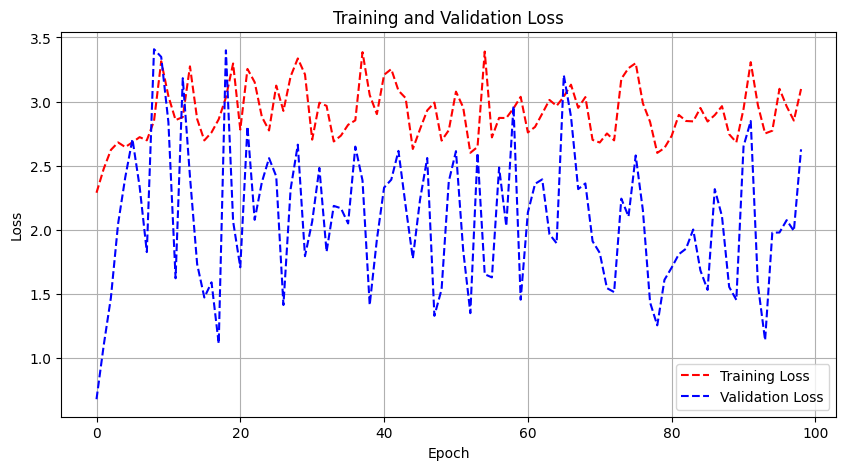

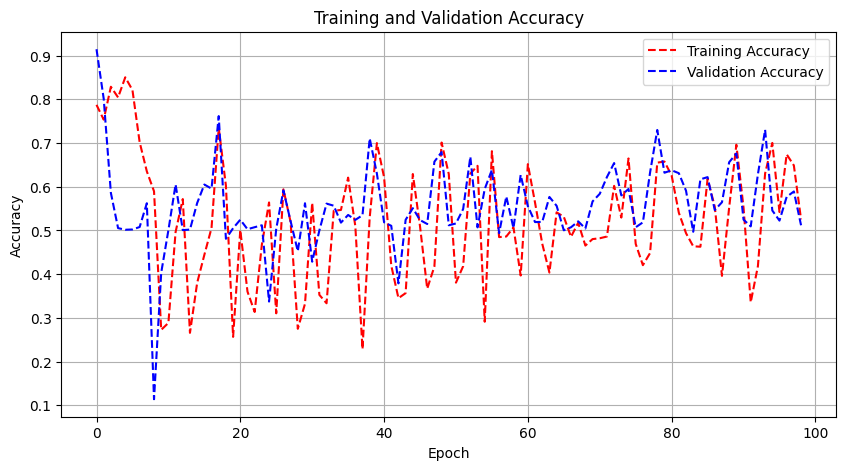

In [16]:
# Reading the data from the saved text file
file_path = 'Results/GANtraining_results.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extracting data from the file
train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []
for line in lines[1:]:  # Skip the header line
    data = line.split('\t')
    train_losses.append(float(data[0]))
    val_losses.append(float(data[1]))
    train_accuracy.append(float(data[2]))
    val_accuracy.append(float(data[3]))

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'--r', label='Training Loss')
plt.plot(val_losses,'--b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy,'--r', label='Training Accuracy')
plt.plot(val_accuracy,'--b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


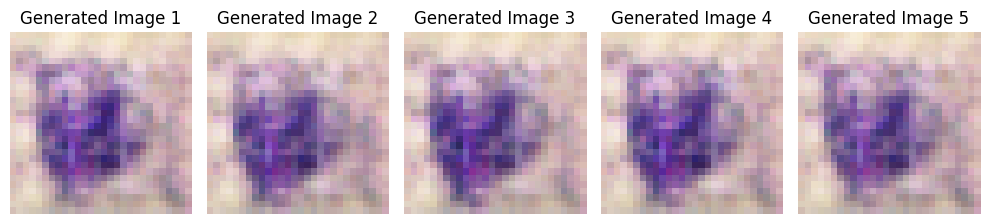

In [17]:

generator = architectures.Generator().to(device)
generator.load_state_dict(torch.load('./ModelWeights/best_generator.pth', map_location=device))
generator.eval()
noise = torch.randn(5,2352,1,1).to(device)
with torch.no_grad():
    fake_images = generator(noise)

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    im = fake_images[i].cpu().detach().numpy()
    im = (np.array(im) +1)/2
    plt.imshow(im.transpose(1, 2, 0))  # Transpose to (H, W, C) for visualization
    plt.axis('off')
    plt.title(f'Generated Image {i+1}')

plt.tight_layout()
plt.show()

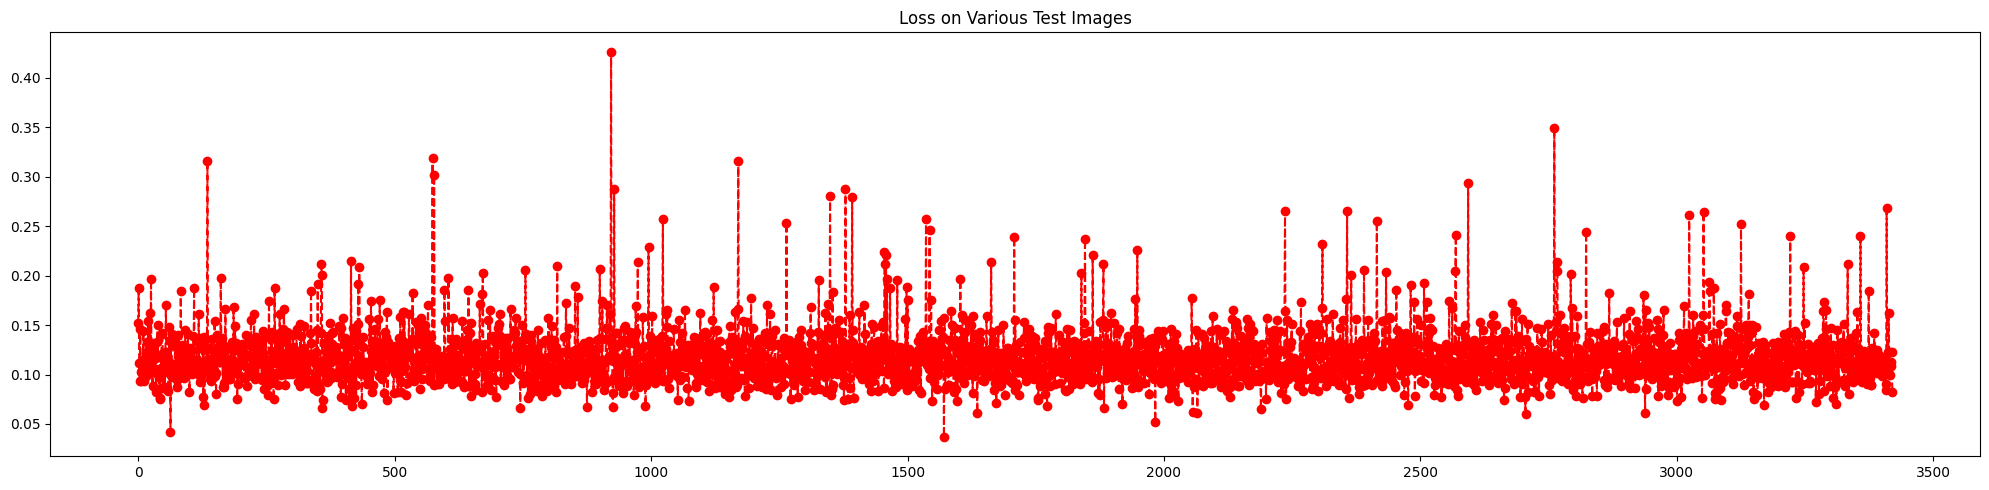

In [18]:

loss = MSELoss()
generator.eval()
l_gan= []
for batch, label in test_loader:
    with torch.no_grad():
        for image in batch:
            generated_image = generator(image.flatten().unsqueeze(dim=0).to(device)).view(-1, 3, 28, 28).to(device)
            l = loss(image.unsqueeze(dim=0).to(device), generated_image)
            l_gan.append(l.cpu().numpy())

plt.figure(figsize=(20,5))
plt.plot(l_gan, '--or')
plt.title("Loss on Various Test Images")
plt.tight_layout()
plt.show()

In [19]:
# Tabulating the results:
import pandas as pd
data = {'VAE_Loss': l_vae, 'GAN_Loss': l_gan}
df = pd.DataFrame(data)
df.head()

,VAE_Loss,GAN_Loss
0,0.34914458,0.15248823
1,0.39213726,0.18718149
2,0.2977195,0.111949064
3,0.25472313,0.09308443
4,0.26694173,0.14600103


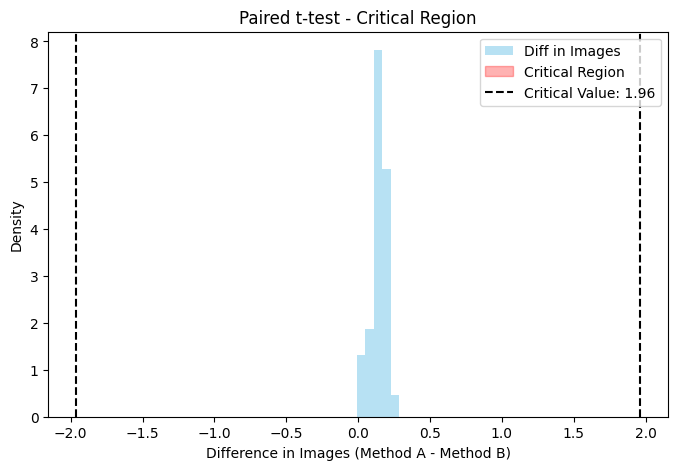

Test Statistic: 164.4289
Critical Value: ±1.9607
P-value: 0.0000


In [20]:
utils.solve(df.VAE_Loss, df.GAN_Loss, alpha=0.05)

In [21]:
utils.power_analysis_1b()

,Effect Size,Sample Size,Power
0,0.20,32,0.123540
1,0.20,64,0.202264
2,0.20,512,0.891962
3,0.20,1024,0.994817
4,0.20,3421,1.000000
5,0.42,32,0.379960
6,0.42,64,0.654610
7,0.42,512,1.000000
8,0.42,1024,1.000000
9,0.42,3421,1.000000


*Observations:*

*As the effect size increases (from 0.2 to 0.42 and then to 0.8), the statistical power generally increases across different sample sizes. Higher effect sizes typically result in higher power, meaning it's easier to detect larger effects.*

*With larger sample sizes, the power tends to increase. For instance, as the sample size grows from 32 to 3421, the power consistently approaches 1.0 for all effect sizes. This illustrates the impact of sample size on the ability to detect effects - larger samples tend to yield higher power.*

*At larger effect sizes (0.42 and 0.8), even smaller sample sizes (e.g., 32 or 64) show relatively high power values, and as the sample size increases further, the power approaches or reaches 1.0, indicating a high likelihood of correctly detecting effects.*

*In summary, this table demonstrates the relationship between effect size, sample size, and statistical power, highlighting that larger effect sizes and sample sizes generally lead to higher statistical power, allowing for better detection of true effects in statistical tests.*

### *Computing the FID on the generated and the Test Images*

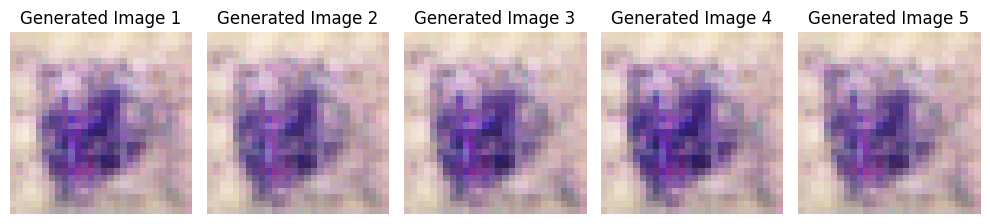

Frechet Inception Distance (FID) between test and generated images: 88.04911322036381


In [22]:
import torch
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

test = iter(test_loader)
batch = next(test)
im, label = batch
im = im[:5] # first five images

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
generator2 = architectures.Generator().to(device)
generator2.load_state_dict(torch.load('./ModelWeights/best_generator.pth', map_location=device))
generator2.eval()

noise = torch.randn(5,2352,1,1).to(device)

with torch.no_grad():
    fake_images = generator2(noise)#im.reshape(5,2352,1,1).to(device))

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    im = fake_images[i].cpu().detach().numpy()
    im = (np.array(im) +1)/2
    plt.imshow(im.transpose(1, 2, 0))  # Transpose to (H, W, C) for visualization
    plt.axis('off')
    plt.title(f'Generated Image {i+1}')

plt.tight_layout()
plt.show()

im = torch.tensor(im)
im = im.repeat(3, 1, 1, 1)  # Duplicates the single channel across 3 channels

# Function to preprocess images (normalize to [0, 1] range)
def preprocess(images):
    images = images * 0.5 + 0.5  # Assuming images are normalized to range [-1, 1], normalize to [0, 1]
    images = torch.clamp(images, 0, 1)  # Clip values to [0, 1]
    return images

# Preprocess the images
test_images_preprocessed = preprocess(im.to(device))
generated_images_preprocessed = preprocess(fake_images.to(device))

# Flatten the images and convert them to numpy arrays
test_activations = test_images_preprocessed.view(test_images_preprocessed.size(0), -1).cpu().numpy()
generated_activations = generated_images_preprocessed.view(generated_images_preprocessed.size(0), -1).cpu().numpy()

# Calculate mean and covariance matrix for test and generated images
mu1 = np.mean(test_activations, axis=0)
mu2 = np.mean(generated_activations, axis=0)
sigma1 = np.cov(test_activations, rowvar=False)
sigma2 = np.cov(generated_activations, rowvar=False)

# Calculate FID score using PCA
eps = 1e-6  # Small epsilon value to avoid numerical issues
sigma1_sqrt = linalg.sqrtm(sigma1 + eps * np.eye(sigma1.shape[0]))
fid = np.linalg.norm(mu1 - mu2)**2 + np.trace(sigma1 + sigma2 - 2 * sigma1_sqrt @ sigma2 @ sigma1_sqrt)

print("Frechet Inception Distance (FID) between test and generated images:", fid)

### *Ans-2-c*

In [25]:
import torch
from scipy.stats import ttest_ind

# Set the device (GPU or CPU)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

generator1 = architectures.VAE(28*28*3).to(device)
generator2 = architectures.Generator().to(device)

# Load the generators (Assuming you've loaded the generators into generator1 and generator2)
generator1.load_state_dict(torch.load('./ModelWeights/best_vae_model.pth', map_location=device))
generator2.load_state_dict(torch.load('./ModelWeights/best_generator.pth', map_location=device))
generator1.eval()
generator2.eval()

# Generate fake images using both generators
with torch.no_grad():
    fake_images_gen1 = generator1.decode(torch.randn(5, 28*28*3).to(device))
    fake_images_gen2 = generator2(torch.randn(5, 2352, 1, 1).to(device))

# Convert the generated images to numpy arrays for scipy t-test
fake_images_gen1_np = fake_images_gen1.cpu().detach().numpy()
fake_images_gen2_np = fake_images_gen2.cpu().detach().numpy()

train = iter(train_loader)
batch = next(train)
images, labels = batch

for i in range(2): # Just checking for 2 images
    gen_1, gen_2, im = fake_images_gen1_np[i], fake_images_gen2_np[i], images[i]
    
    gen_1 = gen_1.flatten()
    gen_2 = gen_2.flatten()
    im = im.flatten()

    # Perform two-sample t-test
    # Perform two-sample t-test between real images and generated images from both models
    t_stat_real_gen1, p_value_real_gen1 = ttest_ind(im, gen_1)
    t_stat_real_gen2, p_value_real_gen2 = ttest_ind(im, gen_2)

    # Perform two-sample t-test between generated images from both models
    t_stat_gen1_gen2, p_value_gen1_gen2 = ttest_ind(gen_1, gen_2)

    # Define significance level (alpha)
    alpha = 0.05

    # Print results
    print(f"Image: {i+1}:")
    # Print results for real vs. generated images comparison
    print("Real Images vs. Generated Images:")
    print(f"t-statistic (Real vs. Gen1): {t_stat_real_gen1}, p-value (Real vs. Gen1): {p_value_real_gen1}")
    print(f"t-statistic (Real vs. Gen2): {t_stat_real_gen2}, p-value (Real vs. Gen2): {p_value_real_gen2}")

    # Print results for generated images comparison between the two models
    print("\nGenerated Images (Gen1 vs. Gen2):")
    print(f"t-statistic (Gen1 vs. Gen2): {t_stat_gen1_gen2}, p-value (Gen1 vs. Gen2): {p_value_gen1_gen2}")

    # Check significance for each comparison
    if p_value_real_gen1 < alpha:
        print("Reject null hypothesis (H0): Real vs. Gen1 - There is a statistically significant difference.")
    else:
        print("Failed to reject null hypothesis (H0): Real vs. Gen1 - There is no statistically significant difference.")

    if p_value_real_gen2 < alpha:
        print("Reject null hypothesis (H0): Real vs. Gen2 - There is a statistically significant difference.")
    else:
        print("Failed to reject null hypothesis (H0): Real vs. Gen2 - There is no statistically significant difference.")

    if p_value_gen1_gen2 < alpha:
        print("Reject null hypothesis (H0): Gen1 vs. Gen2 - There is a statistically significant difference.")
    else:
        print("Failed to reject null hypothesis (H0): Gen1 vs. Gen2 - There is no statistically significant difference.")
    print("")


Image: 1:
Real Images vs. Generated Images:
t-statistic (Real vs. Gen1): 8.161776047068829, p-value (Real vs. Gen1): 4.1998407514288995e-16
t-statistic (Real vs. Gen2): 28.57073019063565, p-value (Real vs. Gen2): 1.0836157460343805e-165

Generated Images (Gen1 vs. Gen2):
t-statistic (Gen1 vs. Gen2): 16.755367168300772, p-value (Gen1 vs. Gen2): 2.999141483474192e-61
Reject null hypothesis (H0): Real vs. Gen1 - There is a statistically significant difference.
Reject null hypothesis (H0): Real vs. Gen2 - There is a statistically significant difference.
Reject null hypothesis (H0): Gen1 vs. Gen2 - There is a statistically significant difference.

Image: 2:
Real Images vs. Generated Images:
t-statistic (Real vs. Gen1): 0.4983834647382561, p-value (Real vs. Gen1): 0.6182371000337727
t-statistic (Real vs. Gen2): 19.55567568040326, p-value (Real vs. Gen2): 6.144382765144993e-82

Generated Images (Gen1 vs. Gen2):
t-statistic (Gen1 vs. Gen2): 20.235312338697224, p-value (Gen1 vs. Gen2): 2.283222

In [26]:
from scipy.stats import ttest_ind
from tabulate import tabulate


results_table = []

for i in range(5):  # Just checking for 2 images
    gen_1, gen_2, im = fake_images_gen1_np[i], fake_images_gen2_np[i], images[i]
    
    gen_1 = gen_1.flatten()
    gen_2 = gen_2.flatten()
    im = im.flatten()


    # Perform two-sample t-test
    # Perform two-sample t-test between real images and generated images from both models
    t_stat_real_gen1, p_value_real_gen1 = ttest_ind(im, gen_1)
    t_stat_real_gen2, p_value_real_gen2 = ttest_ind(im, gen_2)

    # Perform two-sample t-test between generated images from both models
    t_stat_gen1_gen2, p_value_gen1_gen2 = ttest_ind(gen_1, gen_2)

    # Define significance level (alpha)
    alpha = 0.05

    row = [
        f"Image {i+1}",
        f"Real vs. Gen1",
        t_stat_real_gen1,
        p_value_real_gen1,
        "Reject H0" if p_value_real_gen1 < alpha else "Failed to reject H0",
    ]
    results_table.append(row)

    row = [
        f"Image {i+1}",
        f"Real vs. Gen2",
        t_stat_real_gen2,
        p_value_real_gen2,
        "Reject H0" if p_value_real_gen2 < alpha else "Failed to reject H0",
    ]
    results_table.append(row)

    row = [
        f"Image {i+1}",
        f"Gen1 vs. Gen2",
        t_stat_gen1_gen2,
        p_value_gen1_gen2,
        "Reject H0" if p_value_gen1_gen2 < alpha else "Failed to reject H0",
    ]
    results_table.append(row)

headers = ["Image", "Comparison", "t-statistic", "p-value", "Significance"]

#Tabulated results
print(tabulate(results_table, headers=headers, tablefmt="grid"))


+---------+---------------+---------------+--------------+---------------------+
| Image   | Comparison    |   t-statistic |      p-value | Significance        |
+=========+===============+===============+==============+=====================+
| Image 1 | Real vs. Gen1 |      8.16178  | 4.19984e-16  | Reject H0           |
+---------+---------------+---------------+--------------+---------------------+
| Image 1 | Real vs. Gen2 |     28.5707   | 1.08362e-165 | Reject H0           |
+---------+---------------+---------------+--------------+---------------------+
| Image 1 | Gen1 vs. Gen2 |     16.7554   | 2.99914e-61  | Reject H0           |
+---------+---------------+---------------+--------------+---------------------+
| Image 2 | Real vs. Gen1 |      0.498383 | 0.618237     | Failed to reject H0 |
+---------+---------------+---------------+--------------+---------------------+
| Image 2 | Real vs. Gen2 |     19.5557   | 6.14438e-82  | Reject H0           |
+---------+---------------+-

### *Ans-2-d*

i) *From the above statistical tests it is clearly visbile that the generative models be it Variational autoencoder or the Generative adverserial network none can fool statistics, The results clearly show that they are statistically different images.*<br/>
ii) *Whereas If we visualize the images it is very hard to say that the images are real or fake. Thus statistical tools are very powerful for such analysis.*

In [27]:
import numpy as np
import statsmodels.stats.power as smp

# Define parameters for the power analysis
effect_sizes = [0.2, 0.5, 0.8]  # Effect sizes to test
sample_sizes = [20, 50, 100]    # Sample sizes to test
alpha = 0.05                    # Significance level

# Function to perform power analysis for t-tests
def perform_power_analysis(effect_sizes, sample_sizes):
    for effect_size in effect_sizes:
        for sample_size in sample_sizes:
            # Calculate power for real vs. generated images comparison (Gen1)
            power_real_gen1 = smp.TTestIndPower().solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha)

            # Calculate power for real vs. generated images comparison (Gen2)
            power_real_gen2 = smp.TTestIndPower().solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha)

            # Calculate power for generated images comparison between the two models
            power_gen1_gen2 = smp.TTestIndPower().solve_power(effect_size=effect_size * 0.5, nobs1=sample_size, alpha=alpha)

            # Print power results for each comparison
            print(f"Effect Size: {effect_size}, Sample Size: {sample_size}")
            print(f"Power (Real vs. Gen1): {power_real_gen1}")
            print(f"Power (Real vs. Gen2): {power_real_gen2}")
            print(f"Power (Gen1 vs. Gen2): {power_gen1_gen2}")
            print("")

# Perform power analysis
perform_power_analysis(effect_sizes, sample_sizes)


Effect Size: 0.2, Sample Size: 20
Power (Real vs. Gen1): 0.0945673274552083
Power (Real vs. Gen2): 0.0945673274552083
Power (Gen1 vs. Gen2): 0.060959124572486874

Effect Size: 0.2, Sample Size: 50
Power (Real vs. Gen1): 0.16767548634547488
Power (Real vs. Gen2): 0.16767548634547488
Power (Gen1 vs. Gen2): 0.07852398768985816

Effect Size: 0.2, Sample Size: 100
Power (Real vs. Gen1): 0.290645871104774
Power (Real vs. Gen2): 0.290645871104774
Power (Gen1 vs. Gen2): 0.10837184026414252

Effect Size: 0.5, Sample Size: 20
Power (Real vs. Gen1): 0.3379390280664387
Power (Real vs. Gen2): 0.3379390280664387
Power (Gen1 vs. Gen2): 0.12033536754525166

Effect Size: 0.5, Sample Size: 50
Power (Real vs. Gen1): 0.69689340057952
Power (Real vs. Gen2): 0.69689340057952
Power (Gen1 vs. Gen2): 0.23577967269440556

Effect Size: 0.5, Sample Size: 100
Power (Real vs. Gen1): 0.9404271933839895
Power (Real vs. Gen2): 0.9404271933839895
Power (Gen1 vs. Gen2): 0.42053825366059505

Effect Size: 0.8, Sample Size

In [28]:
import numpy as np
import statsmodels.stats.power as smp
import pandas as pd

# Define parameters for the power analysis
effect_sizes = [0.2, 0.5, 0.8]  # Effect sizes to test
sample_sizes = [20, 50, 100]    # Sample sizes to test
alpha = 0.05                    # Significance level

# Function to perform power analysis for t-tests
def perform_power_analysis(effect_sizes, sample_sizes):
    results = []
    for effect_size in effect_sizes:
        for sample_size in sample_sizes:
            # Calculate power for real vs. generated images comparison (Gen1)
            power_real_gen1 = smp.TTestIndPower().solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha)

            # Calculate power for real vs. generated images comparison (Gen2)
            power_real_gen2 = smp.TTestIndPower().solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha)

            # Calculate power for generated images comparison between the two models
            power_gen1_gen2 = smp.TTestIndPower().solve_power(effect_size=effect_size * 0.5, nobs1=sample_size, alpha=alpha)

            results.append({
                'Effect Size': effect_size,
                'Sample Size': sample_size,
                'Power (Real vs. Gen1)': power_real_gen1,
                'Power (Real vs. Gen2)': power_real_gen2,
                'Power (Gen1 vs. Gen2)': power_gen1_gen2
            })

    # Create DataFrame from the results list
    df = pd.DataFrame(results)

    return df

# Perform power analysis and display results in a table
power_analysis_df = perform_power_analysis(effect_sizes, sample_sizes)
power_analysis_df


,Effect Size,Sample Size,Power (Real vs. Gen1),Power (Real vs. Gen2),Power (Gen1 vs. Gen2)
0,0.2,20,0.094567,0.094567,0.060959
1,0.2,50,0.167675,0.167675,0.078524
2,0.2,100,0.290646,0.290646,0.108372
3,0.5,20,0.337939,0.337939,0.120335
4,0.5,50,0.696893,0.696893,0.235780
5,0.5,100,0.940427,0.940427,0.420538
6,0.8,20,0.693404,0.693404,0.234349
7,0.8,50,0.977279,0.977279,0.508186
8,0.8,100,0.999878,0.999878,0.803647


*Effect Size Impact: As the effect size increases (from 0.2 to 0.8), the statistical power of the tests increases across all comparisons.*

*Sample Size Impact: Increasing the sample size generally improves statistical power. For a fixed effect size, larger sample sizes lead to higher power. This relationship is evident in most comparisons, where higher sample sizes correspond to higher power values.*

*Comparing Generations (Gen1 vs. Gen2): Across the different effect sizes and sample sizes, the power differences between Gen1 and Gen2 tend to increase with larger effect sizes and sample sizes. This suggests that larger effect sizes and sample sizes lead to more distinguishable power differences between these generations.*

*Effect Size Comparisons: For a given sample size, larger effect sizes consistently lead to higher power values. This is evident when comparing the power values within each row for different effect sizes but the same sample size.*

*In summary, larger effect sizes and sample sizes generally result in higher statistical power, which means a greater ability to detect true effects. Additionally, the power differences between different effect sizes and sample sizes impact the sensitivity of the statistical tests, influencing the ability to detect differences between generations (Gen1 and Gen2).*